In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from scipy.spatial import distance as dist
from sklearn.neighbors import KNeighborsClassifier
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Loading and normalizing CIFAR10

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading in the CIFAR10 dataset and making the training dataset
trainset = torchvision.datasets.CIFAR10(root='./drive/My Drive/Colab Notebooks/Practicum/data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Loading in the CIFAR10 dataset and making the testing dataset
testset = torchvision.datasets.CIFAR10(root='./drive/My Drive/Colab Notebooks/Practicum/data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


# Defining the classes that could be predicted
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


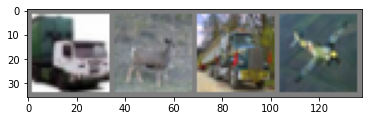

truck  deer truck plane


In [ ]:
# Function to unnormalize and show images from the dataset
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Grab random images and labels from the training dataset  
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show the random images
imshow(torchvision.utils.make_grid(images))

# Print the labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining a CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64,128,5)
        self.fc1 = nn.Linear(128 * 1 * 1, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 1 * 1)
        x = F.relu(self.fc1(x))

        return x

    def get_1st_layer(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        
        return x
    
    def get_2nd_layer(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        return x

    def get_3rd_layer(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        return x

    def get_4th_layer(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 1 * 1)
        x = F.relu(self.fc1(x))

        return x



net = Net()

net.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

# KNN

In [ ]:
train_image = []
train_label = []
test_image = []
test_label = []

for i, data in enumerate(trainloader, 0):
  with torch.no_grad():
    # Train set images and labels
    inputs, labels = data[0].to(device), data[1].to(device)

    train_image += [x.flatten() for x in net.get_3rd_layer(inputs).cpu().numpy()]
    train_label += [x for x in labels.cpu()]




for i, data in enumerate(testloader, 0):
  with torch.no_grad():
    # Test set images and labels
    inputs, labels = data[0].to(device), data[1].to(device)

    test_image += [x.flatten() for x in net.get_3rd_layer(inputs).cpu().numpy()]
    test_label += [x for x in labels.cpu()]



train_image = np.array(train_image)
train_label = np.array(train_label)
test_image = np.array(test_image)
test_label = np.array(test_label)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
neigh.fit(train_image, train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [ ]:
correct = 0
total = 0

for i in range(0, 10000):

  predicted = neigh.predict([test_image[i]])
  # print(neigh.predict_proba([test_image[i]]))
  total = total + 1

  if predicted == test_label[i]:
    correct = correct + 1

knn_accuracy = correct/total * 100


In [ ]:
print(knn_accuracy)

70.66


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [ ]:
with torch.no_grad():
  KNN_probs = neigh.predict_proba( [ x.flatten() for x in net.get_3rd_layer(images.cuda()).cpu().numpy() ] )

In [ ]:
print(KNN_probs)

p_labels = np.argmax(KNN_probs,1)

[[0.         0.         0.         0.85714286 0.         0.14285714
  0.         0.         0.         0.        ]
 [0.         0.28571429 0.         0.         0.         0.
  0.         0.         0.71428571 0.        ]
 [0.14285714 0.57142857 0.         0.         0.         0.
  0.         0.         0.28571429 0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


In [ ]:
correct = 0

correct += (p_labels == labels.cpu().numpy()).sum()

print(correct)

3


# Defining a Loss Function and Optimizer

Classification Cross-Entropy and Adam

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Distance

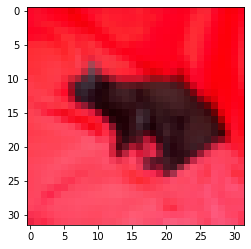

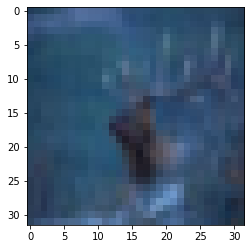

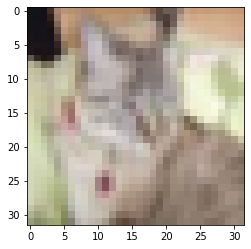

In [ ]:
size = [1, 3, 32, 32]
train_3 = torch.zeros(size)
test_4 = torch.zeros(size)
test_3 = torch.zeros(size)

for i in range(0,49999):
    if trainset[i][1] == 3:
      train_3[0] = trainset[i][0]
    elif testset[i][1] == 4:
      test_4[0] = testset[i][0]
    elif testset[i][1] == 3:
      test_3[0] = testset[i][0]
    
    if LA.norm(train_3) != 0 and LA.norm(test_4) != 0 and LA.norm(test_3) != 0:
      break


imshow(train_3[0])
imshow(test_4[0])
imshow(test_3[0])



In [ ]:
def representation_dist_1(train_3, test_4, test_3):
  with torch.no_grad():
    
    rep_train_3 = net.get_1st_layer(train_3.cuda())
    rep_test_4 = net.get_1st_layer(test_4.cuda())
    rep_test_3 = net.get_1st_layer(test_3.cuda())

    rep_train_3 = rep_train_3.flatten()
    rep_test_4 = rep_test_4.flatten()
    rep_test_3 = rep_test_3.flatten()

    rep_train_3 = rep_train_3.cpu()
    rep_test_4 = rep_test_4.cpu()
    rep_test_3 = rep_test_3.cpu()

    dist_3 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_3/LA.norm(rep_test_3))
    dist_3_4 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_4/LA.norm(rep_test_4))

    cdist_3 = dist.cosine(rep_train_3, rep_test_3)
    cdist_3_4 = dist.cosine(rep_train_3, rep_test_4)

    delta = LA.norm(dist_3 - dist_3_4)

    c_delta = LA.norm(cdist_3 - cdist_3_4)

    return delta, c_delta
 


In [ ]:

def representation_dist_2(train_3, test_4, test_3):
  with torch.no_grad():
    
    rep_train_3 = net.get_2nd_layer(train_3.cuda())
    rep_test_4 = net.get_2nd_layer(test_4.cuda())
    rep_test_3 = net.get_2nd_layer(test_3.cuda())

    rep_train_3 = rep_train_3.flatten()
    rep_test_4 = rep_test_4.flatten()
    rep_test_3 = rep_test_3.flatten()

    rep_train_3 = rep_train_3.cpu()
    rep_test_4 = rep_test_4.cpu()
    rep_test_3 = rep_test_3.cpu()

    dist_3 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_3/LA.norm(rep_test_3))
    dist_3_4 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_4/LA.norm(rep_test_4))

    cdist_3 = dist.cosine(rep_train_3, rep_test_3)
    cdist_3_4 = dist.cosine(rep_train_3, rep_test_4)

    delta = LA.norm(dist_3 - dist_3_4)
    c_delta = LA.norm(cdist_3 - cdist_3_4)

    return delta, c_delta

In [ ]:
def representation_dist_3(train_3, test_4, test_3):
  with torch.no_grad():
    
    rep_train_3 = net.get_3rd_layer(train_3.cuda())
    rep_test_4 = net.get_3rd_layer(test_4.cuda())
    rep_test_3 = net.get_3rd_layer(test_3.cuda())

    rep_train_3 = rep_train_3.flatten()
    rep_test_4 = rep_test_4.flatten()
    rep_test_3 = rep_test_3.flatten()

    rep_train_3 = rep_train_3.cpu()
    rep_test_4 = rep_test_4.cpu()
    rep_test_3 = rep_test_3.cpu()

    dist_3 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_3/LA.norm(rep_test_3))
    dist_3_4 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_4/LA.norm(rep_test_4))

    cdist_3 = dist.cosine(rep_train_3, rep_test_3)
    cdist_3_4 = dist.cosine(rep_train_3, rep_test_4)

    delta = LA.norm(dist_3 - dist_3_4)

    c_delta = LA.norm(cdist_3 - cdist_3_4)

    return delta, c_delta

In [ ]:
def representation_dist_4(train_3, test_4, test_3):
  with torch.no_grad():
    
    rep_train_3 = net.get_4th_layer(train_3.cuda())
    rep_test_4 = net.get_4th_layer(test_4.cuda())
    rep_test_3 = net.get_4th_layer(test_3.cuda())

    rep_train_3 = rep_train_3.flatten()
    rep_test_4 = rep_test_4.flatten()
    rep_test_3 = rep_test_3.flatten()

    rep_train_3 = rep_train_3.cpu()
    rep_test_4 = rep_test_4.cpu()
    rep_test_3 = rep_test_3.cpu()

    dist_3 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_3/LA.norm(rep_test_3))
    dist_3_4 = dist.euclidean(rep_train_3/LA.norm(rep_train_3), rep_test_4/LA.norm(rep_test_4))

    cdist_3 = dist.cosine(rep_train_3, rep_test_3)
    cdist_3_4 = dist.cosine(rep_train_3, rep_test_4)

    delta = LA.norm(dist_3 - dist_3_4)

    c_delta = LA.norm(cdist_3 - cdist_3_4)

    return delta, c_delta

# Training the network

In [ ]:
delta_vals_1 = []
delta_vals_2 = []
delta_vals_3 = []
delta_vals_4 = []

c_delta_vals_1 = []
c_delta_vals_2 = []
c_delta_vals_3 = []
c_delta_vals_4 = []

In [ ]:
for epoch in range(5):

    delta_1, c_delta_1 = representation_dist_1(train_3, test_4, test_3)
    delta_2, c_delta_2 = representation_dist_2(train_3, test_4, test_3)
    delta_3, c_delta_3 = representation_dist_3(train_3, test_4, test_3)
    delta_4, c_delta_4 = representation_dist_4(train_3, test_4, test_3)

    delta_vals_1.append(delta_1)
    delta_vals_2.append(delta_2)
    delta_vals_3.append(delta_3)
    delta_vals_4.append(delta_4)

    c_delta_vals_1.append(c_delta_1)
    c_delta_vals_2.append(c_delta_2)
    c_delta_vals_3.append(c_delta_3)
    c_delta_vals_4.append(c_delta_4)
    
    running_loss = 0.0

    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        # Get the inputs for the CNN. Data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients to prevent gradients from being accumulated to existing gradients
        optimizer.zero_grad()
        
        # Predict based on inputs
        outputs = net(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Perform backprop
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()

        # Calculating the training loss

        # Getting the index of the highest energy. The higher the energy the more confident in the label
        _, predicted = torch.max(outputs.data, 1)


        # Calculating total amount of labels
        total += labels.size(0)

        # Calculating the total amount of images where the predicted label matched the true label
        correct += (predicted == labels).sum().item()

        if i%2000 == 1999: # Print every epoch
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
    
    print(correct/total * 100)

    
delta_1, c_delta_1 = representation_dist_1(train_3, test_4, test_3)
delta_2, c_delta_2 = representation_dist_2(train_3, test_4, test_3)
delta_3, c_delta_3 = representation_dist_3(train_3, test_4, test_3)
delta_4, c_delta_4 = representation_dist_4(train_3, test_4, test_3)

delta_vals_1.append(delta_1)
delta_vals_2.append(delta_2)
delta_vals_3.append(delta_3)
delta_vals_4.append(delta_4)

c_delta_vals_1.append(c_delta_1)
c_delta_vals_2.append(c_delta_2)
c_delta_vals_3.append(c_delta_3)
c_delta_vals_4.append(c_delta_4)   

print('Finished Training')

[1,  2000] loss: 2.073
[1,  4000] loss: 1.706
[1,  6000] loss: 1.480
[1,  8000] loss: 1.410
[1, 10000] loss: 1.324
[1, 12000] loss: 1.255
45.172000000000004
[2,  2000] loss: 1.136
[2,  4000] loss: 1.110
[2,  6000] loss: 1.077
[2,  8000] loss: 1.034
[2, 10000] loss: 1.027
[2, 12000] loss: 0.997
62.804
[3,  2000] loss: 0.912
[3,  4000] loss: 0.870
[3,  6000] loss: 0.877
[3,  8000] loss: 0.860
[3, 10000] loss: 0.891
[3, 12000] loss: 0.838
69.544
[4,  2000] loss: 0.722
[4,  4000] loss: 0.729
[4,  6000] loss: 0.741
[4,  8000] loss: 0.756
[4, 10000] loss: 0.769
[4, 12000] loss: 0.771
73.836
[5,  2000] loss: 0.604
[5,  4000] loss: 0.614
[5,  6000] loss: 0.661
[5,  8000] loss: 0.656
[5, 10000] loss: 0.667
[5, 12000] loss: 0.670
77.378
Finished Training


In [ ]:
print('Training accuracy of the network: %d %%' % (100 * correct/total))

Training accuracy of the network: 77 %


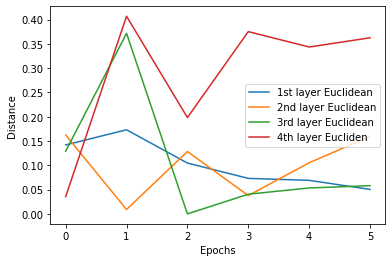

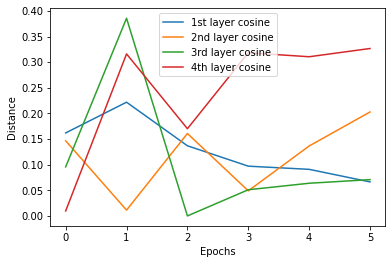

In [ ]:
plt.plot(range(0,len(delta_vals_1)), delta_vals_1, label='1st layer Euclidean')
plt.plot(range(0,len(delta_vals_2)), delta_vals_2, label='2nd layer Euclidean')
plt.plot(range(0,len(delta_vals_3)), delta_vals_3, label='3rd layer Euclidean')
plt.plot(range(0,len(delta_vals_4)), delta_vals_4, label='4th layer Eucliden')

plt.xlabel('Epochs')
plt.ylabel('Distance')
plt.legend()

plt.show()

plt.plot(range(0,len(c_delta_vals_1)), c_delta_vals_1, label='1st layer cosine')
plt.plot(range(0,len(c_delta_vals_2)), c_delta_vals_2, label='2nd layer cosine')
plt.plot(range(0,len(c_delta_vals_3)), c_delta_vals_3, label='3rd layer cosine')
plt.plot(range(0,len(c_delta_vals_4)), c_delta_vals_4, label='4th layer cosine')

plt.xlabel('Epochs')
plt.ylabel('Distance')
plt.legend()

plt.show()

In [ ]:
PATH = './drive/My Drive/Colab Notebooks/Practicum/cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Testing the Classifer on the Whole Dataset

In [ ]:
correct = 0
correct_ens = 0
total = 0

with torch.no_grad():
    for data in testloader:
        # Saving images and labels from data
        images, labels = data[0].to(device), data[1].to(device)
        
        # Predicting the labels
        outputs = net(images)
        
        # Getting the index of the highest energy. The higher the energy the more confident in the label
        _, predicted = torch.max(outputs.data, 1)

        # Probability Distribution from CNN
        CNN_probs = outputs


        # KNN prediction probability distribution
        # with torch.no_grad():
        KNN_probs = neigh.predict_proba( [ x.flatten() for x in net.get_3rd_layer(images).cpu().numpy() ] )


        # Ensemble Prediction
        lam = .75

        ensemble_prob = (1-lam)*CNN_probs.detach().cpu().numpy() + (lam)*KNN_probs

        ensemble_labels = np.argmax(ensemble_prob,1)
        
        # Calculating total amount of labels
        total += labels.size(0)
        
        # Calculating the total amount of images where the predicted label matched the true label
        correct += (predicted == labels).sum().item()
        correct_ens += (ensemble_labels == labels.cpu().numpy()).sum()
          
print('Accuracy of the network on the 10,000 test images: %.3f %%' % (100 * correct/total))
print('Accuracy of the ensemble on the 10,000 test images: %.3f %%' % (100 * correct_ens/total))


Accuracy of the network on the 10,000 test images: 70.320 %
Accuracy of the ensemble on the 10,000 test images: 72.510 %


# Class Performance

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        # Storing the images and labels of the test data
        images, labels = data[0].to(device), data[1].to(device)
        
        # Predicting labels
        outputs = net(images)
        
        # Getting the index of the highest energy.
        _, predicted = torch.max(outputs, 1)
        
        # The amount of correct predictions
        c = (predicted == labels).squeeze()
        
        # Finding how many correct predictions per class
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Printing the accuracy for each class         
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 54 %
Accuracy of   cat : 51 %
Accuracy of  deer : 57 %
Accuracy of   dog : 48 %
Accuracy of  frog : 71 %
Accuracy of horse : 77 %
Accuracy of  ship : 80 %
Accuracy of truck : 69 %


# Loading the Model

In [ ]:
net = Net()

PATH = './drive/My Drive/Colab Notebooks/Practicum/cifar_net.pth'
net.load_state_dict(torch.load(PATH))

net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)